In [1]:
import dwdatareader as dw
import matplotlib.pyplot as plt 
import noisereduce as nr
from IPython.display import Audio
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy.signal import butter,filtfilt
import numpy as np
import acoustics.signal as S
import pandas as pd
import re
import os
import librosa as l
import scipy
import PyOctaveBand
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import scikitplot as skplt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import mixture
from sklearn.svm import SVC
import more_itertools as mit
import seaborn as sns
import math
import os
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from scipy.fftpack import dct
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from numpy import percentile
from model import machine
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import f1_score
from mlxtend.evaluate import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import fbeta_score
import random
from sklearn.feature_selection import RFECV

c:\Users\anand\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_model(train_data, train_label,model_name):
    if model_name=='Random':
        num_trees = 1066 #1000
        max_depth = 98 #100
        model = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=5, criterion="entropy", verbose=0,class_weight='balanced')
        model.fit(train_data, train_label)
    elif model_name=='SVM':
        gamma=1
        C=10
        model=SVC(kernel='rbf',gamma=gamma, C=C,probability=True)
        model.fit(train_data, train_label)
    elif model_name=='Autoencoder':
        print("Autoencoder")
    return model
    
def evaluation_matrix(model, train_data, train_label, test_data, test_label):
    cM=metrics.confusion_matrix(test_label, model.predict(test_data))
    print("Confusion matrix \n",cM)

    bal_accuracy= balanced_accuracy_score(test_label, model.predict(test_data))
    print("Balance Accuracy=",bal_accuracy)
    print("Class wise accuracy",cM.diagonal()/cM.sum(axis=1))
    print("Per class accuracy class 1", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=1))
    print("Per class accuracy class 0", accuracy_score(test_label, model.predict(test_data),method='binary', pos_label=0))
    print("average per class  accuracy", accuracy_score(test_label, model.predict(test_data),method='average'))

    cR=metrics.classification_report(test_label, model.predict(test_data))
    print("ClassificationReport \n",cR)   

    cv = StratifiedKFold(n_splits=5,random_state=11,shuffle=True) # Creating a StratifiedKFold object with 5 folds
    scores = cross_val_score(model,train_data, train_label, cv=cv,scoring="accuracy")
    print('Scores',scores, np.average(scores))

    f1_weighted_1=f1_score(test_label, model.predict(test_data),average='weighted')
    print("F1 weighted",f1_weighted_1)#,f1_weighted_0)
    print("Precison weighted", precision_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))
    print("recall weighted", recall_score(test_label, model.predict(test_data),labels=[1,0] ,average='weighted'))

    print("Confusion matrix \n")
    ConfusionMatrixDisplay.from_predictions(test_label, model.predict(test_data))
    plt.show()
   
    rf_disp = RocCurveDisplay.from_estimator(model, test_data, test_label)
    plt.show()

    fig, ax = plt.subplots(1,2,figsize=(15,6))
    pr = skplt.metrics.plot_precision_recall(test_label, model.predict_proba(test_data),ax=ax[1])
    roc = skplt.metrics.plot_roc(test_label, model.predict_proba(test_data),ax=ax[0])
    plt.show()
    
def undersampling(train_data, train_label):
    rus = RandomUnderSampler()
    undersample_data,undersample_label=rus.fit_resample(train_data, train_label)
    print("Length of train: ", len(undersample_data),"Length of label :", len(undersample_label))
    unique, counts = np.unique(undersample_label, return_counts=True)
    d3=dict(zip(unique, counts))
    print(f"Numbers of class instances (Undersampling): {d3}")
    return undersample_data, undersample_label

def normalize_data(data):
    norm_time=MinMaxScaler()
    norm_time.fit(data.iloc[:,:-1])
    norm_data=norm_time.transform(data.iloc[:,:-1])
    norm_data=pd.concat([pd.DataFrame(norm_data),data.iloc[:,-1:]],axis=1)

    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])
    
    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")
    return norm_data
    
def split_data(data,label):
    indices = np.arange(len(data))
    x_train, x_test, y_train, y_test,indices_train,indices_test= train_test_split(data, label, indices, test_size=0.2,random_state=20,shuffle=True)
    return x_train, x_test, y_train, y_test,indices_train,indices_test
def learning_curve_plot(model,data,label,model_name):
    if model_name=='Random':
        num_trees = 1066 #1000
        max_depth = 98 #100
        model = RandomForestClassifier(n_estimators=num_trees, max_depth=max_depth, min_samples_split=5, criterion="entropy", verbose=0,class_weight='balanced')
    elif model_name=='SVM':
        gamma=1
        C=10
        model=SVC(kernel='rbf',gamma=gamma, C=C,probability=True)
    train_size=[]    
    datasize=int(data.shape[0]*0.8)
    for i in range(0,5):
        train_size.append(random.randint(1,datasize))
    train_size.sort()

    train_sizes,train_scores,validation_scores=learning_curve(estimator=model, X=data, y=label, train_sizes=train_size, cv = 5, scoring = 'balanced_accuracy')

    train_scores_mean = train_scores.mean(axis = 1)
    validation_scores_mean = validation_scores.mean(axis = 1)
    # print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
    # print('\n', '-' * 20) # separator
    # print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
    plt.style.use('seaborn')
    plt.plot(train_sizes, train_scores_mean, label = 'Training Accuracy')
    plt.plot(train_sizes, validation_scores_mean, label = 'Validation Accuracy')
    plt.ylabel('Accuracy', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    plt.title('Learning curves for '+model_name, fontsize = 18, y = 1.03)
    plt.legend()
    plt.show()

file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/II.csv -------------
Numbers of class instances (Raw): {0: 996, 1: 16331}
Numbers of class instances (Raw): {0: 996, 1: 16331}
Length of train:  13861 Length of test : 3466
Numbers of class instances (Train): {0: 791, 1: 13070}
Numbers of class instances (Test): {0: 205, 1: 3261}
Length of train:  1582 Length of label : 1582
Numbers of class instances (Undersampling): {0: 791, 1: 791}
---------------Train Random forest----------------


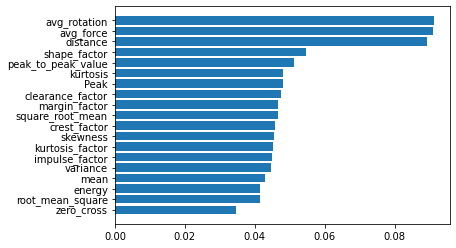

['clearance_factor' 'root_mean_square' 'kurtosis' 'peak_to_peak_value'
 'shape_factor' 'distance' 'avg_rotation' 'avg_force']
file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/II.csv -------------
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Numbers of class instances (Raw): {0: 1072, 1: 17699}
Length of train:  15016 Length of test : 3755
Numbers of class instances (Train): {0: 845, 1: 14171}
Numbers of class instances (Test): {0: 227, 1: 3528}
Length of train:  1690 Length of label : 1690
Numbers of class instances (Undersampling): {0: 845, 1: 845}
---------------Train Random forest----------------


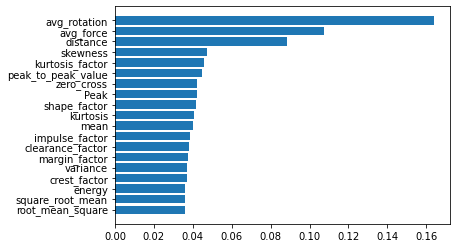

['Peak' 'distance' 'avg_rotation' 'avg_force']
file path-------------- ../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/II.csv -------------
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Numbers of class instances (Raw): {0: 1175, 1: 18318}
Length of train:  15594 Length of test : 3899
Numbers of class instances (Train): {0: 951, 1: 14643}
Numbers of class instances (Test): {0: 224, 1: 3675}
Length of train:  1902 Length of label : 1902
Numbers of class instances (Undersampling): {0: 951, 1: 951}
---------------Train Random forest----------------


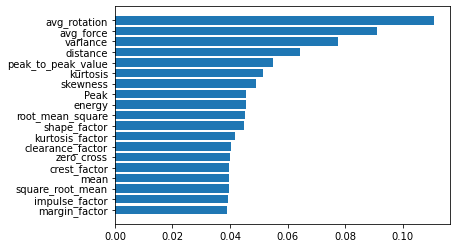

['Peak' 'root_mean_square' 'skewness' 'peak_to_peak_value' 'variance'
 'distance' 'avg_rotation' 'avg_force']


In [4]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/II.csv'
    print("file path--------------",filepath,"-------------")
    df=pd.read_csv(filepath)
    df.columns=time_col_list

    # new_df=df[['avg_rotation','avg_force','root_mean_square','energy','distance','zero_cross','variance','label']]

    ## Normalize data
    norm_data= normalize_data(df)

    ## Separate data and label
    label=np.array(norm_data.iloc[:,-1:]).ravel().astype(int)
    data=np.array(norm_data.iloc[:,:-1])

    unique, counts = np.unique(label, return_counts=True)
    d=dict(zip(unique, counts))
    print(f"Numbers of class instances (Raw): {d}")

    # partition data
    x_train, x_test, y_train, y_test,indices_train,indices_test=split_data(data,label)      

    print("Length of train: ", len(x_train),"Length of test :", len(x_test))

    unique, counts = np.unique(y_train, return_counts=True)
    d1=dict(zip(unique, counts))
    print(f"Numbers of class instances (Train): {d1}")

    unique, counts = np.unique(y_test, return_counts=True)
    d2=dict(zip(unique, counts))
    print(f"Numbers of class instances (Test): {d2}")

    undersample_data, undersample_label=undersampling(x_train,y_train)

    print("---------------Train Random forest----------------")
    model=train_model(undersample_data, undersample_label,'Random')
    f_i = list(zip(time_col_list[:-1],model.feature_importances_))
    f_i.sort(key = lambda x : x[1])
    plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

    plt.show()

    rfe = RFECV(model,cv=5,scoring="neg_mean_squared_error")

    rfe.fit(undersample_data, undersample_label)
    selected_features = np.array(time_col_list[:-1])[rfe.get_support()]
    print(selected_features)

# Parameter tuning SVM Time II

In [27]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/II.csv'
    print(filepath)
    df_II=pd.read_csv(filepath)


    label_II=np.array(df_II.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_II.iloc[:,:-1])
    norm_data_II=norm_time.transform(df_II.iloc[:,:-1])
    print(norm_data_II.shape,label_II.shape)
    combined_II=pd.concat([pd.DataFrame(norm_data_II),df_II.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_II.shape)
    combined_II.head()
    indices = np.arange(combined_II.shape[0])
    x_train_II, x_test, y_train_II, y_test,indices_train,indices_test= train_test_split(combined_II.iloc[:,:-1], np.array(combined_II.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    svc_classifier = SVC()

    grid_param = {'C': [0.1,1, 10, 100],}# 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search.best_params_)

    grid_param = {'gamma': [1,0.1,0.01,0.001]}#,'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search.best_params_)

    grid_param = {'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/II.csv
(17327, 19) (17327,)
(17327, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 0.1}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'rbf'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/II.csv
(18771, 19) (18771,)
(18771, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 0.1}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'rbf'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/II.csv
(19493, 19) (19493,)
(19493, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 0.1}
Fitting 5 folds 

# Parameter tuning SVM III

In [28]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/III.csv'
    print(filepath)
    df_III=pd.read_csv(filepath)


    label_III=np.array(df_III.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_III.iloc[:,:-1])
    norm_data_III=norm_time.transform(df_III.iloc[:,:-1])
    print(norm_data_III.shape,label_III.shape)
    combined_III=pd.concat([pd.DataFrame(norm_data_III),df_III.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_III.shape)
    combined_III.head()
    indices = np.arange(combined_III.shape[0])
    x_train_III, x_test, y_train_III, y_test,indices_train,indices_test= train_test_split(combined_III.iloc[:,:-1], np.array(combined_III.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    svc_classifier = SVC()

    grid_param = {'C': [0.1,1, 10, 100],}# 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search1=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {'gamma': [1,0.1,0.01,0.001]}#,'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search2=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search3=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search3.best_params_)

    grid_param = {'degree': range(3,10,1)}

    grid_search4=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search4.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search4.best_params_)
    

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/III.csv
(6167, 19) (6167,)
(6167, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'poly'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters {'degree': 3}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/III.csv
(6681, 19) (6681,)
(6681, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 0.1}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'rbf'}
Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters {'degree': 3}
../Data/correct_rotation_force/Raw_data/featu

# Parameter tuning SVM IV

In [29]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/IV.csv'
    print(filepath)
    df_IV=pd.read_csv(filepath)


    label_IV=np.array(df_IV.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_IV.iloc[:,:-1])
    norm_data_IV=norm_time.transform(df_IV.iloc[:,:-1])
    print(norm_data_IV.shape,label_IV.shape)
    combined_IV=pd.concat([pd.DataFrame(norm_data_IV),df_IV.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_IV.shape)
    combined_IV.head()
    indices = np.arange(combined_IV.shape[0])
    x_train_IV, x_test, y_train_IV, y_test,indices_train,indices_test= train_test_split(combined_IV.iloc[:,:-1], np.array(combined_IV.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    svc_classifier = SVC()

    grid_param = {'C': [0.1,1, 10, 100],}# 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search1=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {'gamma': [1,0.1,0.01,0.001]}#,'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search2=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search3=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search3.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/IV.csv
(17423, 19) (17423,)
(17423, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'poly'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/IV.csv
(18875, 19) (18875,)
(18875, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 10}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'poly'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/IV.csv
(19601, 19) (19601,)
(19601, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 100}
Fitting 5 folds

# Parameter tuning SVM mfcc II

In [30]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/MFCC/II.csv'
    print(filepath)
    df_II=pd.read_csv(filepath)


    label_II=np.array(df_II.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_II.iloc[:,:-1])
    norm_data_II=norm_time.transform(df_II.iloc[:,:-1])
    print(norm_data_II.shape,label_II.shape)
    combined_II=pd.concat([pd.DataFrame(norm_data_II),df_II.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_II.shape)
    combined_II.head()
    indices = np.arange(combined_II.shape[0])
    x_train_II, x_test, y_train_II, y_test,indices_train,indices_test= train_test_split(combined_II.iloc[:,:-1], np.array(combined_II.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    svc_classifier = SVC()

    grid_param = {'C': [0.1,1, 10, 100],}# 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search.best_params_)

    grid_param = {'gamma': [1,0.1,0.01,0.001]}#,'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search.best_params_)

    grid_param = {'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/MFCC/II.csv
(17327, 120) (17327,)
(17327, 121)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 0.1}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'rbf'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/II.csv
(18771, 120) (18771,)
(18771, 121)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 10}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'rbf'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/II.csv
(19493, 120) (19493,)
(19493, 121)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 10}
Fitting 5 fo

# Parameter tuning SVM MFCC III

In [31]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/MFCC/III.csv'
    print(filepath)
    df_III=pd.read_csv(filepath)


    label_III=np.array(df_III.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_III.iloc[:,:-1])
    norm_data_III=norm_time.transform(df_III.iloc[:,:-1])
    print(norm_data_III.shape,label_III.shape)
    combined_III=pd.concat([pd.DataFrame(norm_data_III),df_III.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_III.shape)
    combined_III.head()
    indices = np.arange(combined_III.shape[0])
    x_train_III, x_test, y_train_III, y_test,indices_train,indices_test= train_test_split(combined_III.iloc[:,:-1], np.array(combined_III.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    svc_classifier = SVC()

    grid_param = {'C': [0.1,1, 10, 100],}# 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search1=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {'gamma': [1,0.1,0.01,0.001]}#,'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search2=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search3=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search3.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/MFCC/III.csv
(6167, 120) (6167,)
(6167, 121)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 1}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'rbf'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/III.csv
(6681, 120) (6681,)
(6681, 121)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 1}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'rbf'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/MFCC/III.csv
(6938, 120) (6938,)
(6938, 121)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 10}
Fitting 5 folds for e

# Parameter tuning SVM MFCC IV

In [32]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/IV.csv'
    print(filepath)
    df_IV=pd.read_csv(filepath)


    label_IV=np.array(df_IV.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_IV.iloc[:,:-1])
    norm_data_IV=norm_time.transform(df_IV.iloc[:,:-1])
    print(norm_data_IV.shape,label_IV.shape)
    combined_IV=pd.concat([pd.DataFrame(norm_data_IV),df_IV.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_IV.shape)
    combined_IV.head()
    indices = np.arange(combined_IV.shape[0])
    x_train_IV, x_test, y_train_IV, y_test,indices_train,indices_test= train_test_split(combined_IV.iloc[:,:-1], np.array(combined_IV.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    svc_classifier = SVC()

    grid_param = {'C': [0.1,1, 10, 100],}# 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search1=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {'gamma': [1,0.1,0.01,0.001]}#,'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search2=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {'kernel': ['rbf', 'poly', 'sigmoid']}

    grid_search3=GridSearchCV(estimator=svc_classifier,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search3.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/IV.csv
(17423, 19) (17423,)
(17423, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 100}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'poly'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/IV.csv
(18875, 19) (18875,)
(18875, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 10}
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'gamma': 1}
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters {'kernel': 'poly'}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/IV.csv
(19601, 19) (19601,)
(19601, 20)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters {'C': 100}
Fitting 5 folds

# Parameter tuning Random II

In [33]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/II.csv'
    print(filepath)
    df_II=pd.read_csv(filepath)


    label_II=np.array(df_II.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_II.iloc[:,:-1])
    norm_data_II=norm_time.transform(df_II.iloc[:,:-1])
    print(norm_data_II.shape,label_II.shape)
    combined_II=pd.concat([pd.DataFrame(norm_data_II),df_II.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_II.shape)
    combined_II.head()
    indices = np.arange(combined_II.shape[0])
    x_train_II, x_test, y_train_II, y_test,indices_train,indices_test= train_test_split(combined_II.iloc[:,:-1], np.array(combined_II.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    rF = RandomForestClassifier(random_state=10)

    grid_param = {"n_estimators": [100,500,700,800,1000,1100]}#,"criterion":['gini','entropy'],"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search1=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {"criterion":['gini','entropy']}#,"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search2=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {"max_depth":[20,40,60,80,100]}#,"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search3=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search3.best_params_)

    grid_param = {"min_samples_leaf":range(1,10,1)}#,"min_samples_split":range(2,10,1)}
    
    grid_search4=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search4.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search4.best_params_)

    grid_param = {"min_samples_split":range(2,10,1)}
    
    grid_search5=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search5.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search5.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/II.csv
(17327, 19) (17327,)
(17327, 20)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 100}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'gini'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters {'max_depth': 60}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters {'min_samples_leaf': 1}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters {'min_samples_split': 4}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/II.csv
(18771, 19) (18771,)
(18771, 20)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 100}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'entropy'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best paramet

# Parameter tuning random III

In [34]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/III.csv'
    print(filepath)
    df_III=pd.read_csv(filepath)


    label_III=np.array(df_III.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_III.iloc[:,:-1])
    norm_data_III=norm_time.transform(df_III.iloc[:,:-1])
    print(norm_data_III.shape,label_III.shape)
    combined_III=pd.concat([pd.DataFrame(norm_data_III),df_III.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_III.shape)
    combined_III.head()
    indices = np.arange(combined_III.shape[0])
    x_train_III, x_test, y_train_III, y_test,indices_train,indices_test= train_test_split(combined_III.iloc[:,:-1], np.array(combined_III.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    rF = RandomForestClassifier(random_state=10)

    grid_param = {"n_estimators": [100,500,700,800,1000,1100]}#,"criterion":['gini','entropy'],"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search1=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {"criterion":['gini','entropy']}#,"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search2=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {"max_depth":[20,40,60,80,100]}#,"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search3=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search3.best_params_)

    grid_param = {"min_samples_leaf":range(1,10,1)}#,"min_samples_split":range(2,10,1)}
    
    grid_search4=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search4.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search4.best_params_)

    grid_param = {"min_samples_split":range(2,10,1)}
    
    grid_search5=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search5.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search5.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/III.csv
(6167, 19) (6167,)
(6167, 20)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 500}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'entropy'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters {'max_depth': 20}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters {'min_samples_leaf': 2}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters {'min_samples_split': 6}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/III.csv
(6681, 19) (6681,)
(6681, 20)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 700}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'entropy'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best paramete

# Parameter tuning random IV

In [35]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/IV.csv'
    print(filepath)
    df_IV=pd.read_csv(filepath)


    label_IV=np.array(df_IV.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_IV.iloc[:,:-1])
    norm_data_IV=norm_time.transform(df_IV.iloc[:,:-1])
    print(norm_data_IV.shape,label_III.shape)
    combined_IV=pd.concat([pd.DataFrame(norm_data_IV),df_IV.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_IV.shape)
    combined_IV.head()
    indices = np.arange(combined_IV.shape[0])
    x_train_IV, x_test, y_train_IV, y_test,indices_train,indices_test= train_test_split(combined_IV.iloc[:,:-1], np.array(combined_IV.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    rF = RandomForestClassifier(random_state=10)

    grid_param = {"n_estimators": [100,500,700,800,1000,1100]}#,"criterion":['gini','entropy'],"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search1=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {"criterion":['gini','entropy']}#,"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search2=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {"max_depth":[20,40,60,80,100]}#,"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search3=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search3.best_params_)

    grid_param = {"min_samples_leaf":range(1,10,1)}#,"min_samples_split":range(2,10,1)}
    
    grid_search4=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search4.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search4.best_params_)

    grid_param = {"min_samples_split":range(2,10,1)}
    
    grid_search5=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search5.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search5.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/IV.csv
(17423, 19) (6938,)
(17423, 20)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 1000}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'entropy'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters {'max_depth': 20}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters {'min_samples_leaf': 9}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters {'min_samples_split': 3}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/IV.csv
(18875, 19) (6938,)
(18875, 20)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 500}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'gini'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best paramete

# Parameter tuning Random MFCC II

In [36]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/MFCC/II.csv'
    print(filepath)
    df_II=pd.read_csv(filepath)


    label_II=np.array(df_II.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_II.iloc[:,:-1])
    norm_data_II=norm_time.transform(df_II.iloc[:,:-1])
    print(norm_data_II.shape,label_II.shape)
    combined_II=pd.concat([pd.DataFrame(norm_data_II),df_II.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_II.shape)
    combined_II.head()
    indices = np.arange(combined_II.shape[0])
    x_train_II, x_test, y_train_II, y_test,indices_train,indices_test= train_test_split(combined_II.iloc[:,:-1], np.array(combined_II.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    rF = RandomForestClassifier(random_state=10)

    grid_param = {"n_estimators": [100,500,700,800,1000,1100]}#,"criterion":['gini','entropy'],"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search1=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {"criterion":['gini','entropy']}#,"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search2=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {"max_depth":[20,40,60,80,100]}#,"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search3=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search3.best_params_)

    grid_param = {"min_samples_leaf":range(1,10,1)}#,"min_samples_split":range(2,10,1)}
    
    grid_search4=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search4.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search4.best_params_)

    grid_param = {"min_samples_split":range(2,10,1)}
    
    grid_search5=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search5.fit(x_train_II,y_train_II)
    print("Best parameters",grid_search5.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/MFCC/II.csv
(17327, 120) (17327,)
(17327, 121)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 100}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'gini'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters {'max_depth': 20}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters {'min_samples_leaf': 1}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters {'min_samples_split': 2}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/II.csv
(18771, 120) (18771,)
(18771, 121)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 100}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'entropy'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best par

# Parameter tuning Random MFCC III

In [37]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/MFCC/III.csv'
    print(filepath)
    df_III=pd.read_csv(filepath)


    label_III=np.array(df_III.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_III.iloc[:,:-1])
    norm_data_III=norm_time.transform(df_III.iloc[:,:-1])
    print(norm_data_III.shape,label_III.shape)
    combined_III=pd.concat([pd.DataFrame(norm_data_III),df_III.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_III.shape)
    combined_III.head()
    indices = np.arange(combined_III.shape[0])
    x_train_III, x_test, y_train_III, y_test,indices_train,indices_test= train_test_split(combined_III.iloc[:,:-1], np.array(combined_III.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    rF = RandomForestClassifier(random_state=10)

    grid_param = {"n_estimators": [100,500,700,800,1000,1100]}#,"criterion":['gini','entropy'],"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search1=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {"criterion":['gini','entropy']}#,"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search2=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {"max_depth":[20,40,60,80,100]}#,"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search3=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search3.best_params_)

    grid_param = {"min_samples_leaf":range(1,10,1)}#,"min_samples_split":range(2,10,1)}
    
    grid_search4=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search4.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search4.best_params_)

    grid_param = {"min_samples_split":range(2,10,1)}
    
    grid_search5=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search5.fit(x_train_III,y_train_III)
    print("Best parameters",grid_search5.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/MFCC/III.csv
(6167, 120) (6167,)
(6167, 121)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 500}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'gini'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters {'max_depth': 20}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters {'min_samples_leaf': 4}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters {'min_samples_split': 8}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/III.csv
(6681, 120) (6681,)
(6681, 121)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 100}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'gini'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters

# Parameter tuning random MFCC IV

In [38]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/MFCC/IV.csv'
    print(filepath)
    df_IV=pd.read_csv(filepath)


    label_IV=np.array(df_IV.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_IV.iloc[:,:-1])
    norm_data_IV=norm_time.transform(df_IV.iloc[:,:-1])
    print(norm_data_IV.shape,label_III.shape)
    combined_IV=pd.concat([pd.DataFrame(norm_data_IV),df_IV.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_IV.shape)
    combined_IV.head()
    indices = np.arange(combined_IV.shape[0])
    x_train_IV, x_test, y_train_IV, y_test,indices_train,indices_test= train_test_split(combined_IV.iloc[:,:-1], np.array(combined_IV.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    # set random forest parameters
    # num_trees = 1066 #1000
    # max_depth = 98 #100
    rF = RandomForestClassifier(random_state=10)

    grid_param = {"n_estimators": [100,500,700,800,1000,1100]}#,"criterion":['gini','entropy'],"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search1=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search1.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search1.best_params_)

    grid_param = {"criterion":['gini','entropy']}#,"max_depth":range(2,20,1),"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search2=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search2.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search2.best_params_)

    grid_param = {"max_depth":[20,40,60,80,100]}#,"min_samples_leaf":range(1,10,1),"min_samples_split":range(2,10,1)}

    grid_search3=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search3.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search3.best_params_)

    grid_param = {"min_samples_leaf":range(1,10,1)}#,"min_samples_split":range(2,10,1)}
    
    grid_search4=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search4.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search4.best_params_)

    grid_param = {"min_samples_split":range(2,10,1)}
    
    grid_search5=GridSearchCV(estimator=rF,param_grid=grid_param,cv=5,n_jobs=-1,verbose=3)
    grid_search5.fit(x_train_IV,y_train_IV)
    print("Best parameters",grid_search5.best_params_)

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/MFCC/IV.csv
(17423, 120) (6938,)
(17423, 121)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 1100}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'gini'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters {'max_depth': 20}
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters {'min_samples_leaf': 4}
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters {'min_samples_split': 5}
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/MFCC/IV.csv
(18875, 120) (6938,)
(18875, 121)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters {'n_estimators': 100}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters {'criterion': 'gini'}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best paramet

# Select k best features

In [39]:
from sklearn.feature_selection import SelectKBest, chi2

In [46]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/II.csv'
    print(filepath)
    df_II=pd.read_csv(filepath)


    label_II=np.array(df_II.iloc[:,-1:]).ravel().astype(int)

    norm_time=MinMaxScaler()
    norm_time.fit(df_II.iloc[:,:-1])
    norm_data_II=norm_time.transform(df_II.iloc[:,:-1])
    print(norm_data_II.shape,label_II.shape)
    combined_II=pd.concat([pd.DataFrame(norm_data_II),df_II.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_II.shape)
    combined_II.head()
    combined_II.columns=time_col_list
    indices = np.arange(combined_II.shape[0])
    x_train_II, x_test, y_train_II, y_test,indices_train,indices_test= train_test_split(combined_II.iloc[:,:-1], np.array(combined_II.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    select_class = SelectKBest(k=7, score_func=chi2)
    select_class.fit(x_train_II, y_train_II)
    x_train_II = select_class.transform(x_train_II)
    print("Num Features before:", x_train_II.shape[1])
    print("Num Features after:", x_train_II.shape[1])
    filter = select_class.get_support()
    
    print("Selected best 8:")
    print(np.array(time_col_list[:-1])[filter])


../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/II.csv
(17327, 19) (17327,)
(17327, 20)
Num Features before: 7
Num Features after: 7
Selected best 8:
['crest_factor' 'skewness' 'shape_factor' 'distance' 'zero_cross'
 'avg_rotation' 'avg_force']
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/II.csv
(18771, 19) (18771,)
(18771, 20)
Num Features before: 7
Num Features after: 7
Selected best 8:
['energy' 'square_root_mean' 'root_mean_square' 'peak_to_peak_value'
 'variance' 'avg_rotation' 'avg_force']
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207011/Feature/Time/II.csv
(19493, 19) (19493,)
(19493, 20)
Num Features before: 7
Num Features after: 7
Selected best 8:
['Peak' 'energy' 'square_root_mean' 'root_mean_square' 'kurtosis'
 'variance' 'avg_force']


In [50]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']
time_col_list=['Peak','energy','impulse_factor','kurtosis_factor','clearance_factor','square_root_mean','root_mean_square','kurtosis','margin_factor','crest_factor','skewness','peak_to_peak_value','shape_factor','mean','variance','distance','zero_cross','avg_rotation','avg_force','label']

for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/III.csv'
    print(filepath)
    df_III=pd.read_csv(filepath)

    label_III=np.array(df_III.iloc[:,-1:]).ravel().astype(int)
    norm_time=MinMaxScaler()
    norm_time.fit(df_III.iloc[:,:-1])
    norm_data_III=norm_time.transform(df_III.iloc[:,:-1])
    print(norm_data_III.shape,label_III.shape)
    combined_III=pd.concat([pd.DataFrame(norm_data_III),df_III.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_III.shape)
    combined_III.head()
    indices = np.arange(combined_III.shape[0])
    x_train_III, x_test, y_train_III, y_test,indices_train,indices_test= train_test_split(combined_III.iloc[:,:-1], np.array(combined_III.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    select_class = SelectKBest(k=7, score_func=chi2)
    select_class.fit(x_train_III, y_train_III)
    x_train_III = select_class.transform(x_train_III)
    print("Num Features before:", x_train_III.shape[1])
    print("Num Features after:", x_train_III.shape[1])
    filter = select_class.get_support()
    
    print("All features",time_col_list[:-1])
    
    print("Selected best 8:")
    print(np.array(time_col_list[:-1])[filter])


../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/III.csv
(6167, 19) (6167,)
(6167, 20)
Num Features before: 7
Num Features after: 7
All features ['Peak', 'energy', 'impulse_factor', 'kurtosis_factor', 'clearance_factor', 'square_root_mean', 'root_mean_square', 'kurtosis', 'margin_factor', 'crest_factor', 'skewness', 'peak_to_peak_value', 'shape_factor', 'mean', 'variance', 'distance', 'zero_cross', 'avg_rotation', 'avg_force']
Selected best 8:
['Peak' 'clearance_factor' 'square_root_mean' 'root_mean_square'
 'peak_to_peak_value' 'distance' 'avg_force']
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/III.csv
(6681, 19) (6681,)
(6681, 20)
Num Features before: 7
Num Features after: 7
All features ['Peak', 'energy', 'impulse_factor', 'kurtosis_factor', 'clearance_factor', 'square_root_mean', 'root_mean_square', 'kurtosis', 'margin_factor', 'crest_factor', 'skewness', 'peak_to_peak_value', 'shape_factor', 'mean', 'variance', 'dist

In [49]:
folder_names=['WKZ_150600_207005','WKZ_150600_207006','WKZ_150600_207011']
for folder in folder_names:
    filepath='../Data/correct_rotation_force/Raw_data/feature/'+folder+'/Feature/Time/IV.csv'
    print(filepath)
    df_IV=pd.read_csv(filepath)

    label_IV=np.array(df_IV.iloc[:,-1:]).ravel().astype(int)
    norm_time=MinMaxScaler()
    norm_time.fit(df_IV.iloc[:,:-1])
    norm_data_IV=norm_time.transform(df_IV.iloc[:,:-1])
    print(norm_data_IV.shape,label_IV.shape)
    combined_IV=pd.concat([pd.DataFrame(norm_data_IV),df_IV.iloc[:,-1:]],axis=1, ignore_index=True)
    print(combined_IV.shape)
    combined_IV.head()
    indices = np.arange(combined_IV.shape[0])
    x_train_IV, x_test, y_train_IV, y_test,indices_train,indices_test= train_test_split(combined_IV.iloc[:,:-1], np.array(combined_IV.iloc[:,-1:]).ravel().astype(int), indices, test_size=0.2,random_state=20,shuffle=True)

    select_class = SelectKBest(k=7, score_func=chi2)
    select_class.fit(x_train_IV, y_train_IV)
    x_train_II = select_class.transform(x_train_IV)
    print("Num Features before:", x_train_IV.shape[1])
    print("Num Features after:", x_train_IV.shape[1])
    filter = select_class.get_support()
    
    print("All features",time_col_list[:-1])
    
    print("Selected best 8:")
    print(np.array(time_col_list[:-1])[filter])

../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207005/Feature/Time/IV.csv
(17423, 19) (17423,)
(17423, 20)
Num Features before: 19
Num Features after: 19
All features ['Peak', 'energy', 'impulse_factor', 'kurtosis_factor', 'clearance_factor', 'square_root_mean', 'root_mean_square', 'kurtosis', 'margin_factor', 'crest_factor', 'skewness', 'peak_to_peak_value', 'shape_factor', 'mean', 'variance', 'distance', 'zero_cross', 'avg_rotation', 'avg_force']
Selected best 8:
['energy' 'kurtosis' 'margin_factor' 'crest_factor' 'shape_factor'
 'distance' 'avg_rotation']
../Data/correct_rotation_force/Raw_data/feature/WKZ_150600_207006/Feature/Time/IV.csv
(18875, 19) (18875,)
(18875, 20)
Num Features before: 19
Num Features after: 19
All features ['Peak', 'energy', 'impulse_factor', 'kurtosis_factor', 'clearance_factor', 'square_root_mean', 'root_mean_square', 'kurtosis', 'margin_factor', 'crest_factor', 'skewness', 'peak_to_peak_value', 'shape_factor', 'mean', 'variance', 'distance', '